In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import os

import statsmodels.api as sms 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
from sklearn import metrics

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")


def MetricasMatrizConfusion(y,Modelo,X,tipo="ML"):
    ## Validar la longitud de los datos
    if (len(y)==len(X)):
        
        if (tipo!="ML"):
            Probabilidad=Modelo.predict(exog=X) # Logit
            Predicciones=np.where(Probabilidad<0.5,0,1)
        else:
            Predicciones=Modelo.predict(X) # Modleo de ML    
        td1=pd.DataFrame(Predicciones,columns=["Predicciones"])
        td2=pd.concat([y.reset_index(drop=True),td1],axis=1)
        td2.columns=["Realidad","Predicciones"]
        Matriz=pd.crosstab(td2["Realidad"],td2["Predicciones"],margins=True)
        
        ## Formato porcentaje
        MatrizNormalizada=pd.crosstab(td2["Realidad"],td2["Predicciones"],normalize=0)
        sns.heatmap(MatrizNormalizada,annot=True,linewidths = 0.01, cmap = "Blues")
        
        ### Métricas, Recall, Precisión
        
        Accuracy =metrics.accuracy_score(y,Predicciones)
        print(f'Accuracy: {Accuracy}')
        Reporte=metrics.classification_report(y,Predicciones)
        print(f'Reporte : {Reporte}')
        
    
    
    else:
        
        Matriz=[]
        print("Los datos no tienen la misma longitud")
    
    
    return Matriz

def curva_roc(y,Modelo,X,tipo="ML"):
    if (tipo!="ML"):
        Probabilidad=Modelo.predict(exog=X) # Logit (statsmodels)
    else:
        Probabilidad=Modelo.predict_proba(X)[:,1] # cuando es Machine Learning(SKlearn) 
        
    roc_auc=roc_auc_score(y,Probabilidad)
    false_positive,true_positive,limites=roc_curve(y,Probabilidad)
    ramdom_probs=[0 for i in range(len(y))]
    c,d,_=roc_curve(y,ramdom_probs,pos_label=1) ## Diagonal
    
    plt.plot(false_positive,true_positive,linestyle="--",color="green",label="AUC: "+str(round(roc_auc,2)))
    plt.plot(c,d,linestyle="--",color="blue")
    plt.xlabel("Tasa Falsos Positivos")
    plt.ylabel("Tasa Verdaderos Positivos")
    plt.legend()
    plt.show()
    return roc_auc

# **Importar Datos** 

In [2]:
os.getcwd()

'/Users/osgaspar/Documents/PERSONAL/Cedesistemas/2023/Diplomado2023_02/ModelosSupervisados/Clasificacion/ProyectoMora'

In [3]:
df=pd.read_csv("BaseModelos.csv")

In [4]:
df.head()

,MontoCredito,Edad,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_0_-1,...,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,Genero_Homologado_Masculino,EducacionHomologada_Posgrado,EducacionHomologada_Pregrado,EstadoCivilHomologado_Otros,EstadoCivilHomologado_Soltero,Mora
0,20000.0,24.0,3913.0,0.0,689.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,1,0,1,0,0,1
1,120000.0,26.0,2682.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,...,0,0,0,0,1,0,1,0,1,1
2,90000.0,34.0,29239.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,...,0,0,0,0,1,0,1,0,1,0
3,50000.0,37.0,46990.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,...,0,0,0,0,1,0,1,0,0,0
4,50000.0,57.0,8617.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,1,...,0,0,0,0,0,0,1,0,0,0


In [5]:
df.shape

(30000, 73)

**Variables Importantes Segun Chi2 y Anova**

In [6]:
Cat_Chi2=pd.read_csv("CatSignificativasChi2.csv")["Variable"].tolist()

In [7]:
len(Cat_Chi2)

54

In [8]:
Num_Anova=pd.read_csv("NumericasSignificativasAnova.csv")["Variable"].tolist()

In [9]:
len(Num_Anova)

9

In [10]:
len(Cat_Chi2)+len(Num_Anova)

63

## **Configurar X e y**

In [11]:
VariablesPredictivas=Cat_Chi2+Num_Anova

In [12]:
len(VariablesPredictivas)

63

In [13]:
X=df[VariablesPredictivas]

In [14]:
X.shape

(30000, 63)

In [15]:
y=df[["Mora"]]

In [16]:
y.shape

(30000, 1)

**Distribucción del Target(Variable Objetivo)**

In [17]:
y.value_counts(normalize=True)

Mora
0       0.7788
1       0.2212
dtype: float64

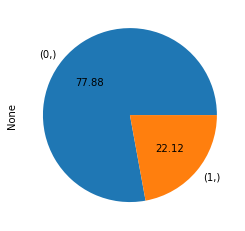

In [18]:
y.value_counts().plot(kind="pie",autopct="%.2f");

## **División Train- Test**

Evaluar la capacidad predictiva de un modelo consiste en comprobar la  aproximación de sus predicciones a los verdaderos valores de la variable respuesta. Para poder cuantificarlo de forma correcta, se necesita disponer de un conjunto de observaciones, de las que se conozca la variable respuesta, pero que el modelo no haya "visto", es decir, que no hayan participado en su ajuste. Con esta finalidad, se dividen los datos disponibles en un conjunto de entrenamiento y un conjunto de prueba.

In [19]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=123, stratify=y)

In [20]:
y_train.value_counts(normalize=True)

Mora
0       0.77881
1       0.22119
dtype: float64

In [21]:
y_test.value_counts(normalize=True)

Mora
0       0.778778
1       0.221222
dtype: float64

## **Modelado**

Los términos inferencia y predicción describen tareas en las que aprendemos de los datos de manera supervisada para encontrar un modelo que describa la relación entre las variables independientes y el resultado. Sin embargo, la inferencia y la predicción divergen cuando se trata del uso del modelo resultante:

* Inferencia: use el modelo para aprender sobre el proceso de generación de datos.
* Predicción: utilice el modelo para predecir los resultados de nuevos puntos de datos

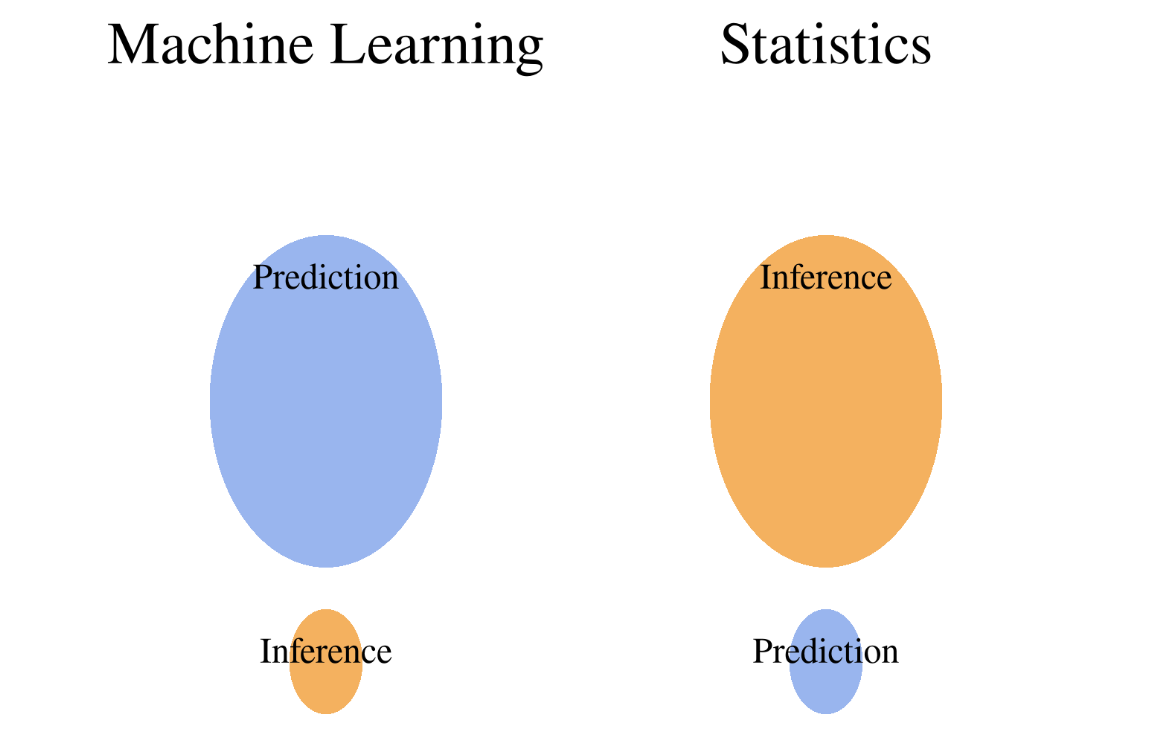

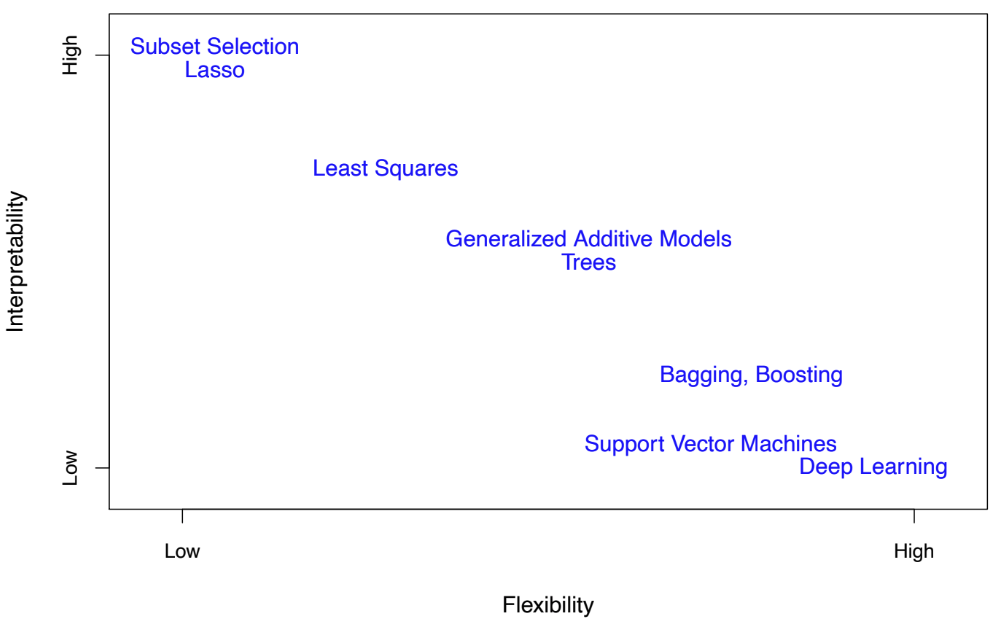

# **Enfoque Estadístico**

La regresión logística es un método estadístico que trata de modelar la probabilidad de una variable cualitativa binaria (dos posibles valores) en función de una o más variables independientes. La principal aplicación de la regresión logística es la creación de modelos de clasificación binaria.

Se llama regresión logística simple cuando solo hay una variable independiente y regresión logística múltiple cuando hay más de una. Dependiendo del contexto, a la variable modelada se le conoce como variable dependiente o variable respuesta, y a las variables independientes como regresores, predictores o features.

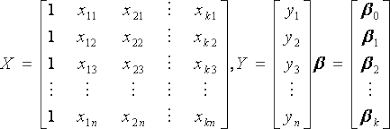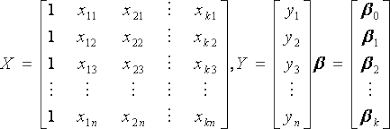

In [22]:
x_train

,PAY_5_6,PAY_0_6,PAY_6_8,PAY_6_5,EducacionHomologada_Pregrado,PAY_0_5,PAY_5_5,EstadoCivilHomologado_Soltero,PAY_0_8,PAY_3_5,...,PAY_0_2,Edad,BILL_AMT1,PAY_AMT6,PAY_AMT5,PAY_AMT3,PAY_AMT4,PAY_AMT2,PAY_AMT1,MontoCredito
14451,0,0,0,0,0,0,0,0,0,0,...,0,52.0,2912.0,780.0,390.0,780.0,780.0,780.0,390.0,20000.0
18392,0,0,0,0,1,0,0,1,0,0,...,0,24.0,160.0,0.0,0.0,12511.0,1249.0,586.0,237.0,230000.0
24955,0,0,0,0,0,0,0,1,0,0,...,0,31.0,0.0,0.0,0.0,3730.0,200.0,0.0,238.0,360000.0
7162,0,0,0,0,1,0,0,0,0,0,...,1,26.0,89947.0,3100.0,3700.0,3500.0,3500.0,4300.0,5000.0,90000.0
12125,0,0,0,0,0,0,0,1,0,0,...,0,29.0,6345.0,300.0,0.0,412.0,694.0,1118.0,0.0,20000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27165,0,0,0,0,1,0,0,0,0,0,...,0,40.0,238094.0,5000.0,10000.0,6000.0,5000.0,8000.0,0.0,280000.0
3228,0,0,0,0,1,0,0,0,0,0,...,0,26.0,43721.0,1340.0,1300.0,1660.0,1457.0,2500.0,2228.0,50000.0
23477,0,0,0,0,1,0,0,1,0,0,...,0,30.0,31708.0,1500.0,0.0,3200.0,1500.0,1850.0,0.0,100000.0
22177,0,0,0,0,1,0,0,1,0,0,...,0,27.0,1261.0,390.0,390.0,1651.0,0.0,1261.0,1261.0,310000.0


In [23]:
y_train

,Mora
14451,0
18392,1
24955,0
7162,0
12125,0
...,...
27165,0
3228,0
23477,1
22177,1


In [24]:
x_train_statsmodels= sms.add_constant(x_train)
x_test_statsmodels= sms.add_constant(x_test)

In [25]:
x_test_statsmodels.head()

,const,PAY_5_6,PAY_0_6,PAY_6_8,PAY_6_5,EducacionHomologada_Pregrado,PAY_0_5,PAY_5_5,EstadoCivilHomologado_Soltero,PAY_0_8,...,PAY_0_2,Edad,BILL_AMT1,PAY_AMT6,PAY_AMT5,PAY_AMT3,PAY_AMT4,PAY_AMT2,PAY_AMT1,MontoCredito
45,1.0,0,0,0,0,0,0,0,1,0,...,0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,210000.0
18762,1.0,0,0,0,0,0,0,0,1,0,...,0,29.0,52898.0,84363.0,0.0,0.0,0.0,0.0,3000.0,420000.0
9341,1.0,0,0,0,0,1,0,0,1,0,...,0,35.0,67306.0,2000.0,1700.0,1600.0,1600.0,2310.0,3400.0,70000.0
21814,1.0,0,0,0,0,1,0,0,1,0,...,0,26.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,180000.0
25950,1.0,0,0,0,0,0,0,0,0,0,...,0,32.0,388.0,4200.0,8000.0,388.0,110345.0,388.0,388.0,410000.0


In [26]:
## Intanciar Modelos
Modelo_Logit=sms.Logit(endog=y_train,exog=x_train_statsmodels).fit(method="bfgs") # method="bfgs"

         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3


In [27]:
Modelo_Logit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
==========================================================================
Model:                 Logit               Pseudo R-squared:    -0.312    
Dependent Variable:    Mora                AIC:                 29240.1816
Date:                  2023-11-22 18:57    BIC:                 29749.1274
No. Observations:      21000               Log-Likelihood:      -14556.   
Df Model:              63                  LL-Null:             -11097.   
Df Residuals:          20936               LLR p-value:         1.0000    
Converged:             0.0000              Scale:               1.0000    
--------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z|   [0.025 0.975]
--------------------------------------------------------------------------
const                         0.0000   0.1038 0.0000 1.0000 -0.2034 0.2034
PAY_5_6                       0.0000   2.3486 0.0000 1.0000 -4.6032 4.6032
PAY_0_6                       0.0000   1.0610 0.0000 1.0000 -2.0795 2.0795
PAY_6_8                       0.0000   2.0047 0.0000 1.0000 -3.9291 3.9291
PAY_6_5                       0.0000   0.8044 0.0000 1.0000 -1.5765 1.5765
EducacionHomologada_Pregrado  0.0000   0.0405 0.0000 1.0000 -0.0795 0.0795
PAY_0_5                       0.0000   0.5769 0.0000 1.0000 -1.1308 1.1308
PAY_5_5                       0.0000   0.9779 0.0000 1.0000 -1.9167 1.9167
EstadoCivilHomologado_Soltero 0.0000   0.0318 0.0000 1.0000 -0.0623 0.0623
PAY_0_8                       0.0000   2.2090 0.0000 1.0000 -4.3296 4.3296
PAY_3_5                       0.0000   0.8708 0.0000 1.0000 -1.7067 1.7067
PAY_0_7                       0.0000   1.6313 0.0000 1.0000 -3.1973 3.1973
PAY_2_7                       0.0000   2.7671 0.0000 1.0000 -5.4233 5.4233
PAY_4_5                       0.0000   0.8372 0.0000 1.0000 -1.6408 1.6408
Genero_Homologado_Masculino   0.0000   0.0286 0.0000 1.0000 -0.0561 0.0561
PAY_2_6                       0.0000   1.6414 0.0000 1.0000 -3.2170 3.2170
PAY_3_6                       0.0000   1.5472 0.0000 1.0000 -3.0326 3.0326
PAY_2_5                       0.0000   0.8160 0.0000 1.0000 -1.5994 1.5994
PAY_6_6                       0.0000   1.0392 0.0000 1.0000 -2.0368 2.0368
PAY_2_4                       0.0000   0.3525 0.0000 1.0000 -0.6908 0.6908
PAY_6_4                       0.0000   0.4894 0.0000 1.0000 -0.9592 0.9592
EducacionHomologada_Posgrado  0.0000   0.0444 0.0000 1.0000 -0.0870 0.0870
PAY_3_7                       0.0000   0.6249 0.0000 1.0000 -1.2247 1.2247
PAY_3_4                       0.0000   0.4434 0.0000 1.0000 -0.8690 0.8690
PAY_5_4                       0.0000   0.4607 0.0000 1.0000 -0.9030 0.9030
PAY_4_4                       0.0000   0.4564 0.0000 1.0000 -0.8945 0.8945
PAY_6_-1                      0.0000   0.0758 0.0000 1.0000 -0.1486 0.1486
PAY_0_-1                      0.0000   0.0977 0.0000 1.0000 -0.1916 0.1916
PAY_0_4                       0.0000   0.3142 0.0000 1.0000 -0.6158 0.6158
PAY_6_7                       0.0000   1.2165 0.0000 1.0000 -2.3842 2.3842
PAY_6_0                       0.0000   0.0802 0.0000 1.0000 -0.1572 0.1572
PAY_5_0                       0.0000   0.1074 0.0000 1.0000 -0.2105 0.2105
PAY_5_-1                      0.0000   0.0979 0.0000 1.0000 -0.1920 0.1920
PAY_5_7                       0.0000   2.2234 0.0000 1.0000 -4.3578 4.3578
PAY_4_7                       0.0000   2.0639 0.0000 1.0000 -4.0451 4.0451
PAY_4_-1                      0.0000   0.0988 0.0000 1.0000 -0.1936 0.1936
PAY_2_-1                      0.0000   0.1057 0.0000 1.0000 -0.2073 0.2073
PAY_4_0                       0.0000   0.1091 0.0000 1.0000 -0.2137 0.2137
PAY_3_-1                      0.0000   0.0966 0.0000 1.0000 -0.1894 0.1894
PAY_4_3                       0.0000   0.2479 0.0000 1.0000 -0.4859 0.4859
PAY_3_3                       0.0000   0.2254 0.0000 1.0000 -0.4418 0.4418
PAY_5_

## **Supuesto de los Modelos Lineales**

Un modelo lineal, en el contexto de regresión lineal, se basa en varios supuestos clave para que sus estimaciones y predicciones sean válidas y confiables. Aquí están los supuestos más comunes de un modelo de regresión lineal:

* y= b0+b1*x1+b2*x2+e


* Linealidad: El supuesto fundamental es que la relación entre las variables independientes (predictoras) y la variable dependiente (respuesta) es lineal. Esto significa que el efecto de un cambio en una variable predictora es constante, independientemente del valor de las otras variables.

* Independencia de errores: Se asume que los errores (residuos) del modelo no están correlacionados entre sí. En otras palabras, no debe haber patrones sistemáticos en los errores. La independencia de errores es esencial para que las estimaciones de los coeficientes sean no sesgadas y eficientes.

* Homocedasticidad: Significa que la varianza de los errores debe ser constante en todos los niveles de las variables predictoras. En otras palabras, la dispersión de los errores debe ser uniforme a lo largo de toda la gama de valores de las variables predictoras.

* Normalidad de errores: Se asume que los errores siguen una distribución normal. Esto es importante para realizar inferencias estadísticas y pruebas de hipótesis sobre los coeficientes del modelo.

* No multicolinealidad: Se espera que las variables predictoras no estén altamente correlacionadas entre sí, ya que la multicolinealidad puede dificultar la interpretación de los coeficientes y hacer que las estimaciones sean inestables.

* Ausencia de endogeneidad: Se asume que las variables predictoras no están correlacionadas con los errores del modelo. La endogeneidad puede introducir sesgos en las estimaciones.

* Ausencia de valores atípicos (outliers): Valores atípicos pueden distorsionar las estimaciones y, por lo tanto, se asume que no hay valores atípicos que afecten significativamente el modelo.

## **Identifcar multicolinealidad**

**El Análisis de VIF (Variance Inflation Factor, por sus siglas en inglés)**


La multicolinealidad entre variables independientes en un modelo de regresión. La multicolinealidad es una situación en la que dos o más variables independientes en un modelo de regresión están altamente correlacionadas entre sí, lo que puede causar problemas al estimar los coeficientes de regresión y dificultar la interpretación de los resultados.

El VIF mide cuánto se infla la varianza de los coeficientes de regresión debido a la multicolinealidad. Un VIF alto indica una alta multicolinealidad y sugiere que una variable es predecible a partir de las otras en el modelo. Generalmente, se considera que un VIF mayor a 10 o 5 indica multicolinealidad problemática

In [28]:
x=x_test_statsmodels.drop(["const","MontoCredito","Edad"],axis=1)

In [29]:
ResultadoVif=pd.DataFrame()

ResultadoVif["Variable"]=x.columns
ResultadoVif["Vif"]=[variance_inflation_factor(x.values,i) for i in range(len(x.columns)) ]   

In [30]:
ResultadoVif.sort_values("Vif",ascending=False).head(10)

,Variable,Vif
0,PAY_5_6,inf
8,PAY_0_8,inf
15,PAY_3_6,inf
11,PAY_2_7,inf
45,PAY_2_0,43.605290
42,PAY_3_0,33.515874
36,PAY_4_0,33.428210
30,PAY_5_0,32.258169
33,PAY_4_7,28.737410
47,PAY_0_0,26.490873


In [31]:
EliminarVif=ResultadoVif["Variable"][ResultadoVif["Vif"]>=4].tolist()
print(f'La cantidad: {len(EliminarVif)} y son: {EliminarVif}')

La cantidad: 27 y son: ['PAY_5_6', 'PAY_0_8', 'PAY_0_7', 'PAY_2_7', 'PAY_2_6', 'PAY_3_6', 'PAY_6_-1', 'PAY_0_-1', 'PAY_6_7', 'PAY_6_0', 'PAY_5_0', 'PAY_5_-1', 'PAY_5_7', 'PAY_4_7', 'PAY_4_-1', 'PAY_2_-1', 'PAY_4_0', 'PAY_3_-1', 'PAY_3_0', 'PAY_2_0', 'PAY_0_0', 'PAY_6_2', 'PAY_5_2', 'PAY_4_2', 'PAY_3_2', 'PAY_2_2', 'PAY_0_2']


In [32]:
x_test_statsmodelsVif=x_test_statsmodels.drop(columns=EliminarVif)
x_train_statsmodelsVif=x_train_statsmodels.drop(columns=EliminarVif)

In [33]:
Modelo_LogitFinal=sms.Logit(endog=y_train,exog=x_train_statsmodelsVif).fit(method="bfgs") 

         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3


In [34]:
Modelo_LogitFinal.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
==========================================================================
Model:                 Logit               Pseudo R-squared:    -0.312    
Dependent Variable:    Mora                AIC:                 29186.1816
Date:                  2023-11-22 18:57    BIC:                 29480.4159
No. Observations:      21000               Log-Likelihood:      -14556.   
Df Model:              36                  LL-Null:             -11097.   
Df Residuals:          20963               LLR p-value:         1.0000    
Converged:             0.0000              Scale:               1.0000    
--------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z|   [0.025 0.975]
--------------------------------------------------------------------------
const                         0.0000   0.0880 0.0000 1.0000 -0.1724 0.1724
PAY_0_6                       0.0000   0.9235 0.0000 1.0000 -1.8100 1.8100
PAY_6_8                       0.0000   2.0009 0.0000 1.0000 -3.9217 3.9217
PAY_6_5                       0.0000   0.6402 0.0000 1.0000 -1.2548 1.2548
EducacionHomologada_Pregrado  0.0000   0.0405 0.0000 1.0000 -0.0794 0.0794
PAY_0_5                       0.0000   0.5626 0.0000 1.0000 -1.1027 1.1027
PAY_5_5                       0.0000   0.8935 0.0000 1.0000 -1.7512 1.7512
EstadoCivilHomologado_Soltero 0.0000   0.0317 0.0000 1.0000 -0.0622 0.0622
PAY_3_5                       0.0000   0.6180 0.0000 1.0000 -1.2112 1.2112
PAY_4_5                       0.0000   0.5754 0.0000 1.0000 -1.1277 1.1277
Genero_Homologado_Masculino   0.0000   0.0285 0.0000 1.0000 -0.0559 0.0559
PAY_2_5                       0.0000   0.7123 0.0000 1.0000 -1.3961 1.3961
PAY_6_6                       0.0000   0.6110 0.0000 1.0000 -1.1975 1.1975
PAY_2_4                       0.0000   0.3324 0.0000 1.0000 -0.6515 0.6515
PAY_6_4                       0.0000   0.4763 0.0000 1.0000 -0.9335 0.9335
EducacionHomologada_Posgrado  0.0000   0.0442 0.0000 1.0000 -0.0865 0.0865
PAY_3_7                       0.0000   0.4391 0.0000 1.0000 -0.8607 0.8607
PAY_3_4                       0.0000   0.4206 0.0000 1.0000 -0.8243 0.8243
PAY_5_4                       0.0000   0.4425 0.0000 1.0000 -0.8673 0.8673
PAY_4_4                       0.0000   0.4362 0.0000 1.0000 -0.8549 0.8549
PAY_0_4                       0.0000   0.3036 0.0000 1.0000 -0.5951 0.5951
PAY_4_3                       0.0000   0.2157 0.0000 1.0000 -0.4227 0.4227
PAY_3_3                       0.0000   0.1934 0.0000 1.0000 -0.3790 0.3790
PAY_5_3                       0.0000   0.2084 0.0000 1.0000 -0.4085 0.4085
PAY_6_3                       0.0000   0.2186 0.0000 1.0000 -0.4285 0.4285
PAY_2_3                       0.0000   0.1456 0.0000 1.0000 -0.2854 0.2854
PAY_0_1                       0.0000   0.0429 0.0000 1.0000 -0.0841 0.0841
PAY_0_3                       0.0000   0.1376 0.0000 1.0000 -0.2697 0.2697
Edad                          0.0000   0.0018 0.0000 1.0000 -0.0035 0.0035
BILL_AMT1                     0.0000   0.0000 0.0000 1.0000 -0.0000 0.0000
PAY_AMT6                      0.0000   0.0000 0.0000 1.0000 -0.0000 0.0000
PAY_AMT5                      0.0000   0.0000 0.0000 1.0000 -0.0000 0.0000
PAY_AMT3                      0.0000   0.0000 0.0000 1.0000 -0.0000 0.0000
PAY_AMT4                      0.0000   0.0000 0.0000 1.0000 -0.0000 0.0000
PAY_AMT2                      0.0000   0.0000 0.0000 1.0000 -0.0000 0.0000
PAY_AMT1                      0.0000   0.0000 0.0000 1.0000 -0.0000 0.0000
MontoCredito                  0.0000   0.0000 0.0000 1.0000 -0.0000 0.0000
==========================================================================

"""

## **Eliminación Automática de Variables**

La eliminación automática de variables en un modelo de regresión, ya sea hacia adelante o hacia atrás, es un enfoque para seleccionar un subconjunto óptimo de características predictoras en función de ciertos criterios. Estos métodos ayudan a simplificar el modelo y reducir la multicolinealidad, el sobreajuste y el ruido, lo que puede mejorar la capacidad predictiva del modelo.

## **Forward Selection**

Eliminación hacia adelante (Forward Selection): En este enfoque, comienzas con un modelo vacío (sin variables predictoras) y luego iterativamente agregas una 
variable a la vez. En cada paso, seleccionas la variable que proporciona la mejora más significativa en el ajuste del modelo (por ejemplo, reduce el error residual o aumenta el estadístico F). Continúas agregando variables hasta que no haya más mejoras significativas. Esto se hace generalmente con la ayuda de criterios estadísticos, como el valor p o el valor F

## **Backward Elimination**

Eliminación hacia atrás (Backward Elimination): En este enfoque, comienzas con un modelo que incluye todas las variables predictoras y luego, en cada paso, eliminas la variable que menos contribuye al ajuste del modelo. Continúas eliminando variables hasta que no haya más variables que puedan eliminarse sin empeorar significativamente el modelo.

* https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html
* Se recomienda ensañar los dos enfoques

In [35]:
#modelo_base=LogisticRegression()

In [36]:
#Selector=SequentialFeatureSelector(modelo_base,direction="forward") #forward
#Selector.fit(x_train_statsmodelsVif,y_train)

In [37]:
##Eleccion=x_train_statsmodelsVif.columns[Selector.get_support()].tolist()

In [38]:
Eleccion=['const',
 'PAY_0_6',
 'PAY_6_8',
 'PAY_6_5',
 'EducacionHomologada_Pregrado',
 'PAY_0_5',
 'PAY_5_5',
 'EstadoCivilHomologado_Soltero',
 'PAY_3_5',
 'PAY_4_5',
 'Genero_Homologado_Masculino',
 'PAY_6_6',
 'PAY_3_7',
 'PAY_5_4',
 'PAY_5_3',
 'PAY_2_3',
 'PAY_0_3',
 'Edad']


In [39]:
x_test_statsmodelsForward=x_test_statsmodels[Eleccion]
x_train_statsmodelsForward=x_train_statsmodels[Eleccion]

In [40]:
Modelo_LogitForward=sms.Logit(endog=y_train,exog=x_train_statsmodelsForward).fit(method="bfgs") 

         Current function value: 0.514422
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


In [41]:
Modelo_LogitForward.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Results: Logit
==============================================================================
Model:                  Logit                Pseudo R-squared:     0.026      
Dependent Variable:     Mora                 AIC:                  21641.7132 
Date:                   2023-11-22 18:57     BIC:                  21784.8542 
No. Observations:       21000                Log-Likelihood:       -10803.    
Df Model:               17                   LL-Null:              -11097.    
Df Residuals:           20982                LLR p-value:          6.2117e-114
Converged:              0.0000               Scale:                1.0000     
------------------------------------------------------------------------------
                               Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------------
const                         -1.1132   0.0956 -11.6417 0.0000 -1.3006 -0.9258
PAY_0_6                        0.0848   0.8779   0.0966 0.9231 -1.6358  1.8053
PAY_6_8                        0.0277   2.3452   0.0118 0.9906 -4.5689  4.6243
PAY_6_5                        0.1170   0.7357   0.1591 0.8736 -1.3250  1.5590
EducacionHomologada_Pregrado   0.0798   0.0341   2.3419 0.0192  0.0130  0.1466
PAY_0_5                        0.1322   0.5499   0.2405 0.8100 -0.9456  1.2100
PAY_5_5                        0.1115   0.9174   0.1216 0.9033 -1.6865  1.9096
EstadoCivilHomologado_Soltero -0.1514   0.0385  -3.9279 0.0001 -0.2269 -0.0758
PAY_3_5                        0.0980   0.5714   0.1716 0.8638 -1.0220  1.2181
PAY_4_5                        0.1500   0.5396   0.2781 0.7810 -0.9076  1.2076
Genero_Homologado_Masculino   -0.1882   0.0345  -5.4535 0.0000 -0.2558 -0.1205
PAY_6_6                        0.1712   0.6778   0.2525 0.8006 -1.1573  1.4996
PAY_3_7                        0.4855   0.4787   1.0140 0.3106 -0.4529  1.4238
PAY_5_4                        0.6432   0.3378   1.9038 0.0569 -0.0190  1.3053
PAY_5_3                        1.2952   0.1951   6.6377 0.0000  0.9127  1.6776
PAY_2_3                        1.7737   0.1443  12.2943 0.0000  1.4909  2.0565
PAY_0_3                        2.2206   0.1608  13.8087 0.0000  1.9054  2.5358
Edad                          -0.0015   0.0021  -0.7401 0.4592 -0.0057  0.0026
==============================================================================

"""

## **Regresión Lasso y Ridge (Regularización del Modelo)**

* Pseudo R-squared: 0.026 es un indicador de qué tan bien se ajusta el modelo a los datos. El valor de 0.026 es bajo, lo que sugiere que el modelo puede no ser muy bueno para explicar la variabilidad en la variable dependiente. Cuanto más cercano a 1 esté el R-squared (o pseudo R-squared), mejor se ajusta el modelo a los datos

**exp(coef)**

In [42]:
coefientes=Modelo_LogitForward.params
odds_ratios=np.exp(coefientes)
odds_ratios

const                            0.328498
PAY_0_6                          1.088463
PAY_6_8                          1.028083
PAY_6_5                          1.124154
EducacionHomologada_Pregrado     1.083091
PAY_0_5                          1.141370
PAY_5_5                          1.117963
EstadoCivilHomologado_Soltero    0.859514
PAY_3_5                          1.103012
PAY_4_5                          1.161884
Genero_Homologado_Masculino      0.828489
PAY_6_6                          1.186675
PAY_3_7                          1.624936
PAY_5_4                          1.902510
PAY_5_3                          3.651689
PAY_2_3                          5.892684
PAY_0_3                          9.212800
Edad                             0.998452
dtype: float64

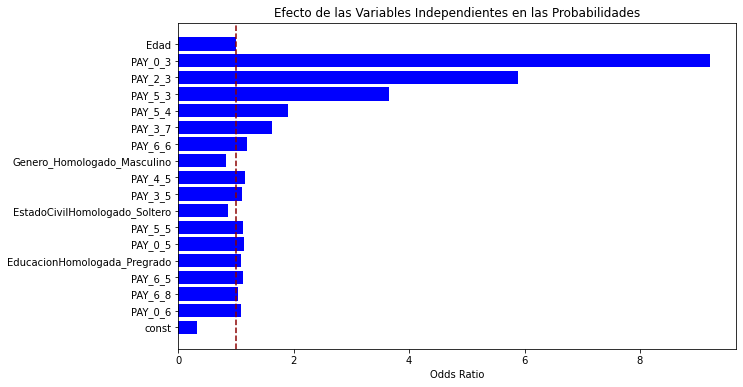

In [43]:
Variables=odds_ratios.index.tolist()
exp=odds_ratios.values.tolist()
plt.figure(figsize=(10, 6))
plt.barh(Variables, exp, color='blue')
plt.axvline(x=1,color="darkred",linestyle="--")
plt.xlabel('Odds Ratio')
plt.title('Efecto de las Variables Independientes en las Probabilidades');

# **Interpretación de coefiecientes**

**Variables Numéricas**

* Edad:-0.0015: Cuando la variable Edad del cliente aumenta en 1 año, los odds (ratio de logaritmos de las probabilidades) disminuye en 0.0015
 
* Edad  e(coef)= 0.998452; (1-0.99)*100: 0.15 %; Para cada año que el cliente aumenta su edad, las probabilidades de que incurra en Mora disminuyen 0.15%

* La concluisón es viable si es estadisticamente significativa

* P valor:0.4592: si el p valor es menor a 0.05, la variable es estadisticamnete significativa, de lo contrario no podemos concluir nada sobre ella.

**Variables Categóricas**

* EstadoCivilHomologado_Soltero	-0.1514; Las clientes solteros, disminyen los odds (ratio de logaritmos de las probabilidades)  en 0.15 en comparación a los clientes No solteros

* EstadoCivilHomologado_Soltero    0.859514: (1-0.859514)*100=14%; Los usuairos solteros disminuyen la probabilidad de caer en mora en 14% con respecto a los usuarios no solteros

* P valor: 0.0001: como el p valor es menor a 0.05, la relación anterior es estadisticamente viable

## **Validar la Normalidad**


En la regresión lineal, se evalúan los residuos tal cual; sin embargo, los residuos del modelo de regresión logística deben transformarse para que sean útiles. Esto se debe a que la variable dependiente es binaria (0 o 1). Debido a la naturaleza binaria del resultado, los residuos no se distribuirán normalmente y se desconoce su distribución (Nachtsheim, Neter y Li, 2004). Los residuales evaluados entonces son los residuales de Pearson, los residuales de Pearson estudentizados y/o los residuales de desviación .

Una gráfica que es útil para diagnosticar el modelo de regresión logística es trazar los residuos de Pearson estudentizados, o los residuos de desviación, contra la probabilidad estimada o los valores predictores lineales con un suavizado de Lowess. Nachtsheim, Neter y Li (2004) muestran que, bajo el supuesto de que el modelo de regresión logística es correcto, el error (diferencia) entre el valor observado () y el valor predicho (
) es igual a 0, es decir
Concluyen que esto sugiere que un lowess smooth de una de las gráficas mencionadas anteriormente sería aproximadamente una línea horizontal con intersección cero; 

desafortunadamente, no brindan una sugerencia de cómo se ve "aproximadamente". Al observar las visualizaciones, es importante tener en cuenta que el tamaño y la escala de la imagen afectarán el aspecto de la visualización y, por lo tanto, afectarán la interpretación.

Ahora, para demostrar esto. StatsModels calcula los residuos de Pearson estudentizados (model.resid_pearson), así como los residuos de desviación (model.resid_dev) de forma predeterminada, lo que nos ahorra algo de tiempo.

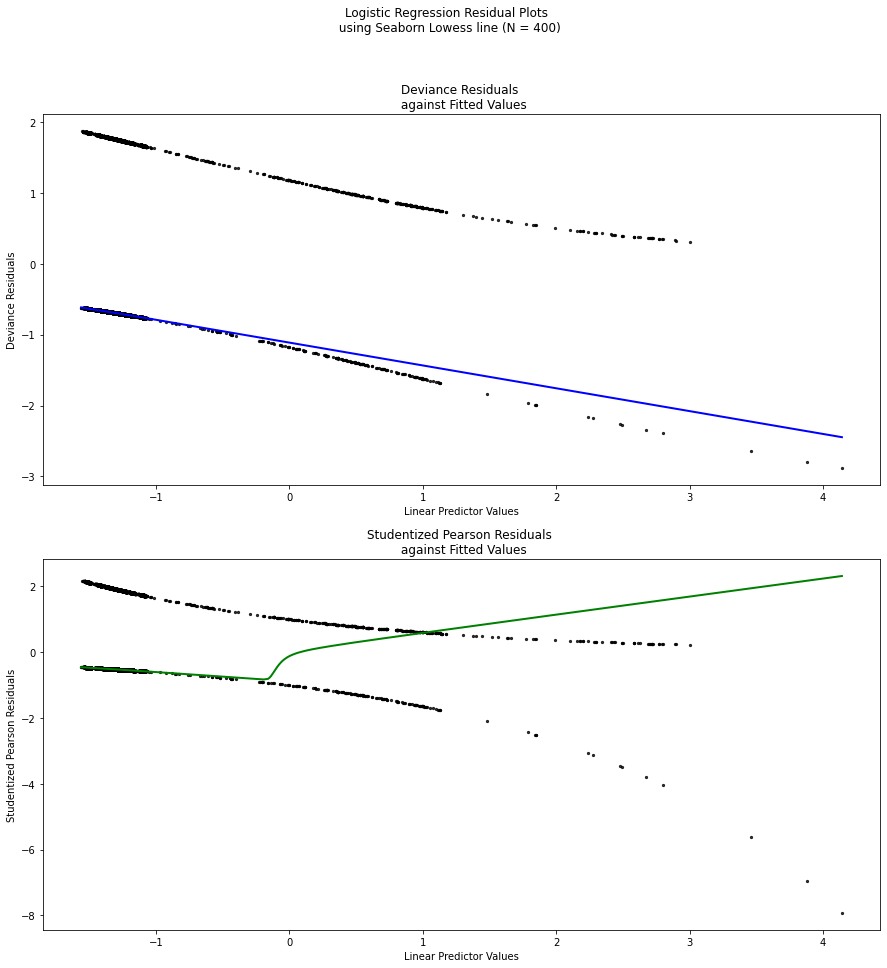

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear una figura con dos subplots
fig, (axL, axR) = plt.subplots(2, figsize=(15, 15))
plt.suptitle("Logistic Regression Residual Plots \n using Seaborn Lowess line (N = 400)")

# Deviance Residuals
x_data_dev = Modelo_LogitForward.fittedvalues.tolist()
y_data_dev = Modelo_LogitForward.resid_dev.tolist()

sns.regplot(x=x_data_dev, y=y_data_dev, ax=axL, color="black", scatter_kws={"s": 5}, line_kws={"color": "b", "alpha": 1, "lw": 2}, lowess=True)

axL.set_title("Deviance Residuals \n against Fitted Values")
axL.set_xlabel("Linear Predictor Values")
axL.set_ylabel("Deviance Residuals")

# Studentized Pearson Residuals
x_data_pearson = Modelo_LogitForward.fittedvalues.tolist()
y_data_pearson = Modelo_LogitForward.resid_pearson.tolist()

sns.regplot(x=x_data_pearson, y=y_data_pearson, ax=axR, color="black", scatter_kws={"s": 5}, line_kws={"color": "g", "alpha": 1, "lw": 2}, lowess=True)

axR.set_title("Studentized Pearson Residuals \n against Fitted Values")
axR.set_xlabel("Linear Predictor Values")
axR.set_ylabel("Studentized Pearson Residuals")

plt.show()


## **¿Poder Predictivo?**

## **Evaluación en Entranamiento**

### **La matriz de confusión**

La matriz de confusión es una herramienta fundamental en el campo de la clasificación en aprendizaje automático y estadísticas. Se utiliza para evaluar el rendimiento de un modelo de clasificación al comparar las predicciones del modelo con los valores reales o etiquetas de las observaciones en un conjunto de datos. La matriz de confusión muestra la cantidad de predicciones correctas e incorrectas que realiza un modelo, y es especialmente útil cuando se trabaja con problemas de clasificación binaria (dos clases) o clasificación multiclase (más de dos clases).

La matriz de confusión se compone de cuatro elementos principales:

* Verdaderos Positivos (TP - True Positives): Representa el número de observaciones que el modelo predijo correctamente como positivas (clase positiva) cuando en realidad eran positivas.

* Falsos Negativos (FN - False Negatives): Indica el número de observaciones que el modelo predijo incorrectamente como negativas (clase negativa) cuando en realidad eran positivas.

* Falsos Positivos (FP - False Positives): Muestra el número de observaciones que el modelo predijo incorrectamente como positivas cuando en realidad eran negativas.

* Verdaderos Negativos (TN - True Negatives): Representa la cantidad de observaciones que el modelo predijo correctamente como negativas cuando en realidad eran negativas.

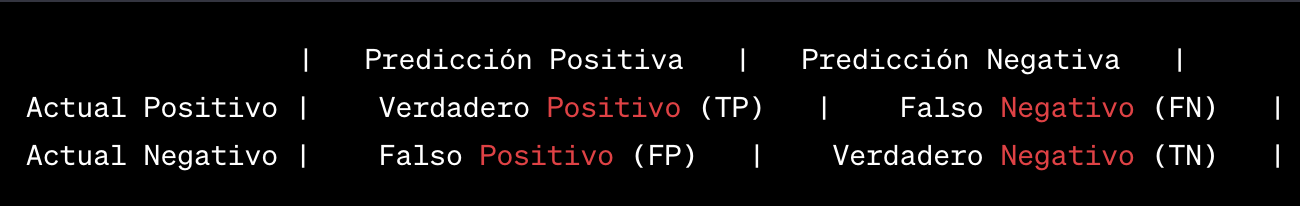

In [45]:
Probabilidad=Modelo_LogitForward.predict(exog=x_train_statsmodelsForward)

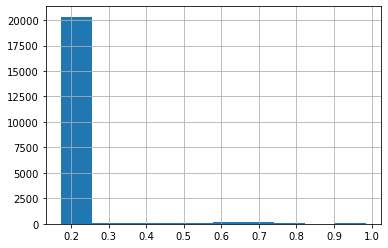

In [46]:
Probabilidad.hist();

In [47]:
Predicciones=np.where(Probabilidad<0.5,0,1)

In [48]:
Predicciones

array([0, 0, 0, ..., 0, 0, 0])

In [49]:
td1=pd.DataFrame(Predicciones,columns=["Predicciones"])
td2=pd.concat([y_train.reset_index(drop=True),td1],axis=1)
td2.columns=["Realidad","Predicciones"]
pd.crosstab(td2["Realidad"],td2["Predicciones"],margins=True)

Predicciones,0,1,All
Realidad,,,
0,16195,160,16355
1,4321,324,4645
All,20516,484,21000


* V(+): V(1): 324
* V(-): V(0): 16195
* F+: 160
* F-: 4321

### **Accuracy**

La "accuracy" (exactitud) es una métrica de evaluación común en el campo del aprendizaje automático y la estadística, especialmente en problemas de clasificación. Mide la proporción de predicciones correctas realizadas por un modelo en relación con el total de observaciones en un conjunto de datos.


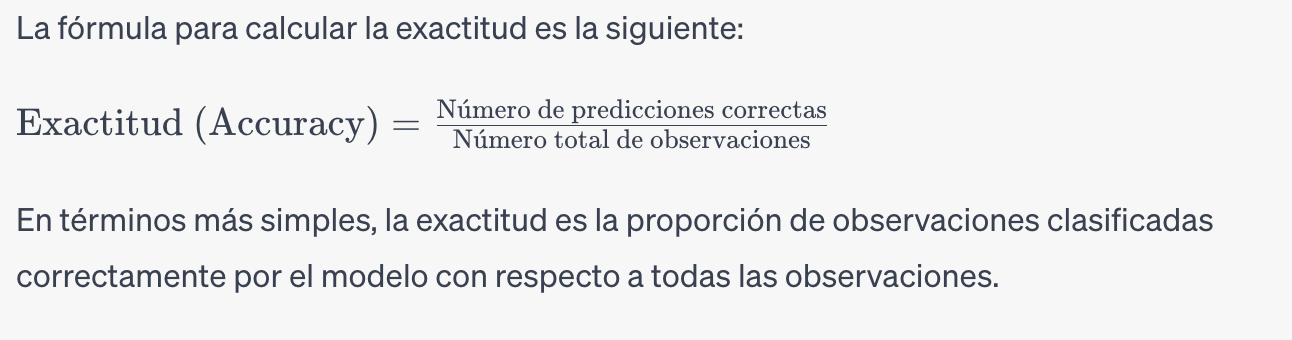

In [50]:
AccuracyTrain=((16195+324)/21000)*100

In [51]:
AccuracyTrain

78.66190476190476

Un valor de precisión (accuracy) del 78.66% en un modelo de mora significa que el modelo clasificó correctamente el 78.66% de las observaciones en el conjunto de datos. 

En otras palabras, aproximadamente el 78.66% de las predicciones realizadas por el modelo fueron correctas en relación con el total de observaciones en el conjunto de datos utilizado para la evaluación del modelo.

Este valor de precisión es un indicador de qué tan bien el modelo está funcionando en términos generales.

Sin embargo, la interpretación precisa del significado de este valor depende del contexto específico del problema de mora que estás abordando y de la importancia relativa de las predicciones correctas en tu situación.

**Pero para datos desbalanceados, esta metrica no se recomienda, debido a que el modelo esta sesgado hacia la clase mayoritaria**

### **Precisión**

La precisión para una clase específica se refiere a la proporción de predicciones correctas para esa clase en particular en un problema de clasificación. Se suele calcular en relación con el total de predicciones que el modelo hizo para esa clase.

En un contexto de clasificación binaria, generalmente hay dos clases: la "clase positiva" y la "clase negativa". La precisión para la "clase positiva" se calcula de la siguiente manera:

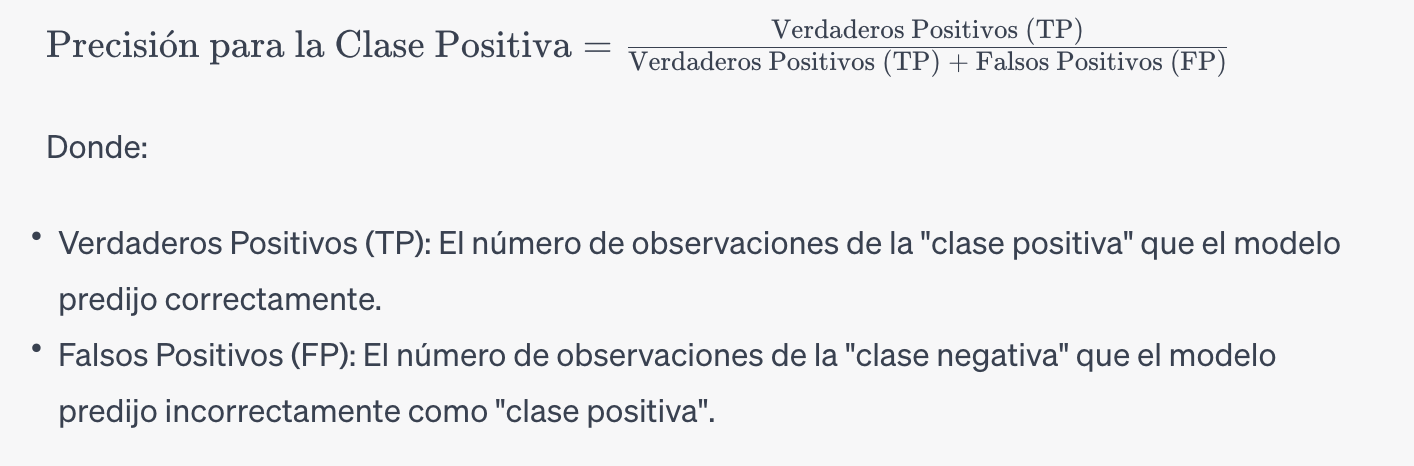

In [52]:
PrecisionMorosos=((324)/(324+160))*100

In [53]:
PrecisionMorosos

66.94214876033058

In [54]:
PrecisionNoMorosos=((16195)/(16195+4321))*100

In [55]:
PrecisionNoMorosos

78.93838954961981

## **Recuperación (Recall)**

La recuperación mide la proporción de casos positivos reales que fueron identificados correctamente por el modelo. En el contexto de la mora de crédito, si un modelo de clasificación tiene un recall del 90%, significa que identifica el 90% de los casos de mora en el conjunto de datos.

* Recuperación = Verdaderos Positivos / (Verdaderos Positivos + Falsos Negativos)

In [56]:
RecallMorosos=((324)/(324+4321))*100

In [57]:
RecallMorosos

6.97524219590958

In [58]:
RecallNoMorosos=((16195)/(16195+160))*100

In [59]:
RecallNoMorosos

99.02170590033629


* Modelos con Alto Recall y Alto Precisión

## **f1 score**

El F1 score tiene un valor entre 0 y 1, y busca encontrar un equilibrio entre la precisión y la recuperación. Un valor alto de F1 score indica que el modelo es bueno tanto en la precisión como en la recuperación, mientras que un valor bajo de F1 score puede indicar que el modelo está sesgado hacia una de las dos métricas (precisión o recuperación) a expensas de la otra.

## **Métricas con Python**

##  **Trade - off Sesgo - Varianza**

**Rendimiento Modelo en Train**
* Métricas Altas, Buenas

In [60]:
x_train_statsmodelsForward.shape

(21000, 18)

Accuracy: 0.7866190476190477
Reporte :               precision    recall  f1-score   support

           0       0.79      0.99      0.88     16355
           1       0.67      0.07      0.13      4645

    accuracy                           0.79     21000
   macro avg       0.73      0.53      0.50     21000
weighted avg       0.76      0.79      0.71     21000



Predicciones,0,1,All
Realidad,,,
0,16195,160,16355
1,4321,324,4645
All,20516,484,21000


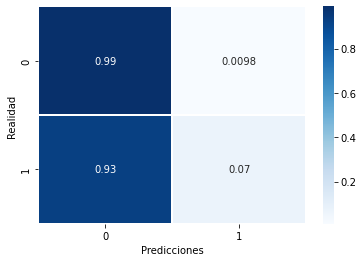

In [61]:
MetricasMatrizConfusion(y=y_train,Modelo=Modelo_LogitForward,X=x_train_statsmodelsForward,tipo="Logit")

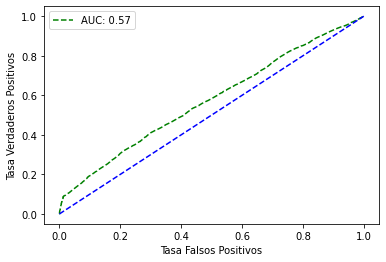

0.5731789391656266

In [62]:
curva_roc(y=y_train,Modelo=Modelo_LogitForward,X=x_train_statsmodelsForward,tipo="Logit")

## **Rendimiento Modelo en Test**

Accuracy: 0.7866666666666666
Reporte :               precision    recall  f1-score   support

           0       0.79      0.99      0.88      7009
           1       0.68      0.07      0.12      1991

    accuracy                           0.79      9000
   macro avg       0.74      0.53      0.50      9000
weighted avg       0.77      0.79      0.71      9000



Predicciones,0,1,All
Realidad,,,
0,6947,62,7009
1,1858,133,1991
All,8805,195,9000


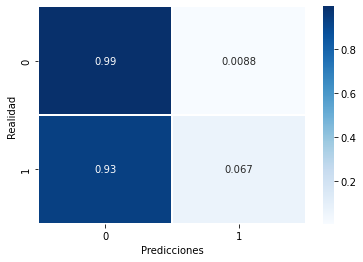

In [63]:
MetricasMatrizConfusion(y=y_test,Modelo=Modelo_LogitForward,X=x_test_statsmodelsForward,tipo="Logit")

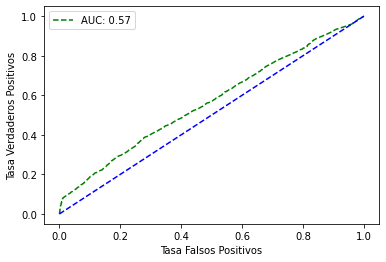

0.5662450280076867

In [64]:
curva_roc(y=y_test,Modelo=Modelo_LogitForward,X=x_test_statsmodelsForward,tipo="Logit")

# **Modelos Machine Learning (Poder Predictivo)**
* https://pycaret.org/
* https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/

## **Arbol de Clasificación**

In [65]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text

### **Entrenamiento Simple**

In [66]:
Arbol_Simple=DecisionTreeClassifier(random_state=1) ## Por default, instanciado
## Ajusta a los datos
Arbol_Simple.fit(x_train,y_train)

DecisionTreeClassifier(random_state=1)

In [67]:
Arbol_Simple.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

* criterion: Especifica la función para medir la calidad de una división. Puede ser "gini" para medir la impureza de Gini o "entropy" para medir la ganancia de información. El valor predeterminado es "gini".

* max_depth: Controla la profundidad máxima del árbol. Limitar la profundidad del árbol puede ayudar a prevenir el sobreajuste. Si no se establece, los nodos se expandirán hasta que contengan menos de min_samples_split muestras.

* min_samples_split: El número mínimo de muestras requeridas para dividir un nodo interno. Este parámetro controla la prevención del sobreajuste estableciendo el límite inferior en el tamaño de la muestra para una división.

* min_samples_leaf: El número mínimo de muestras requeridas para estar en un nodo hoja. Controla el tamaño mínimo de las hojas del árbol y también ayuda a prevenir el sobreajuste.

* max_features: a cantidad máxima de características a considerar al buscar la mejor división. Puede ser un número entero, un porcentaje o una cadena como "sqrt" o "log2". Esto controla la aleatoriedad y puede mejorar la generalización.

* random_state: Controla la aleatoriedad en la construcción del árbol. Proporcionar un valor fijo garantiza reproducibilidad en los resultados.

* class_weight: Puede tomar los valores "balanced" o un diccionario que asigne pesos a las clases. Esto puede ser útil cuando las clases están desbalanceadas, ya que asigna más importancia a las clases menos representadas.


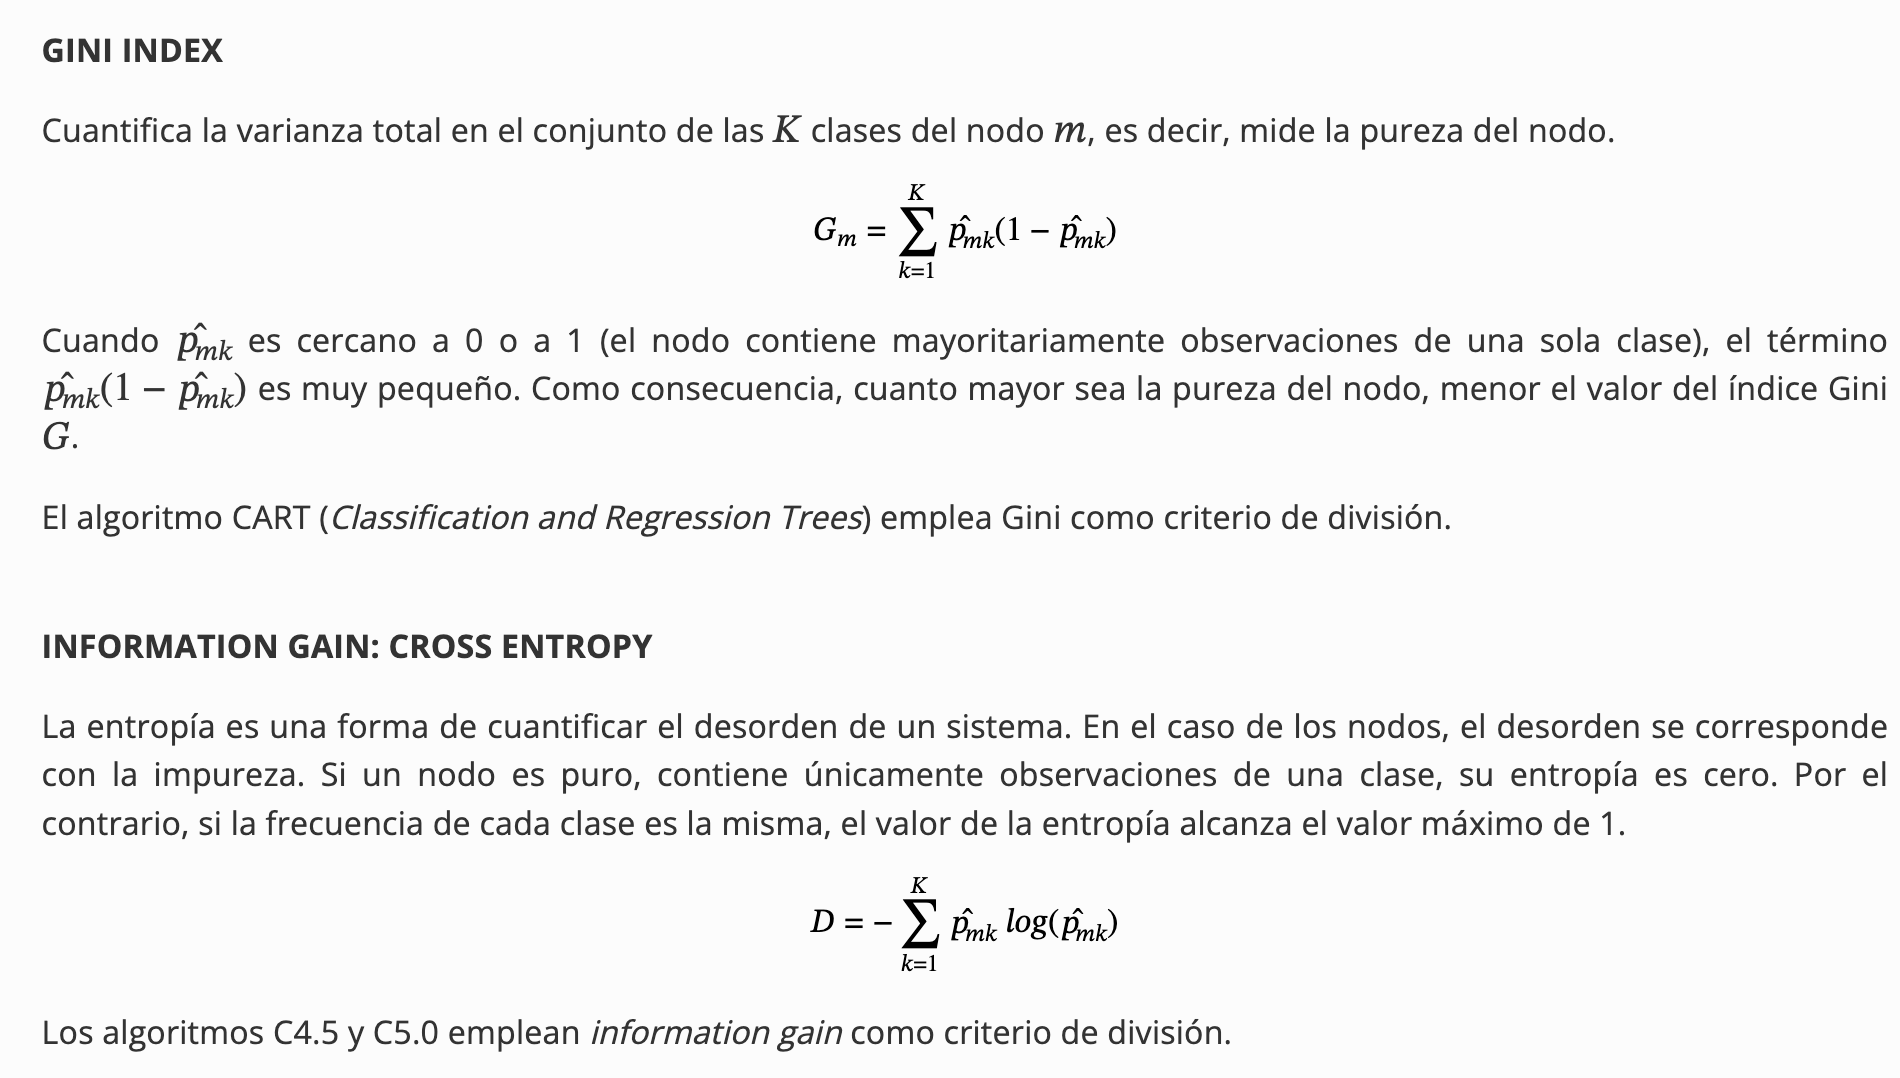

**Gráfica**

In [68]:
#fig, ax= plt.subplots(figsize=(30,15))
#plot=plot_tree(decision_tree=Arbol_Simple,
#              feature_names=x_train.columns,
#              class_names="Predicción Mora",
#              ax=ax)

### **Importancia de Variables**

In [69]:
Importancia_Predictores=pd.DataFrame(
{"predictor":x_train.columns,
 "Importancia":Arbol_Simple.feature_importances_})

Importancia_Predictores=Importancia_Predictores.sort_values("Importancia",ascending=False).reset_index(drop=True)
Importancia_Predictores

,predictor,Importancia
0,PAY_0_2,0.121763
1,BILL_AMT1,0.102421
2,Edad,0.100324
3,MontoCredito,0.079988
4,PAY_AMT2,0.078272
...,...,...
58,PAY_2_6,0.000000
59,PAY_3_7,0.000000
60,PAY_5_4,0.000000
61,PAY_5_7,0.000000


#### **Gráfica de importancia**

### **Evaluar Poder Predictivo**

**Train Error**

Accuracy: 0.9994761904761905
Reporte :               precision    recall  f1-score   support

           0       1.00      1.00      1.00     16355
           1       1.00      1.00      1.00      4645

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000



Predicciones,0,1,All
Realidad,,,
0,16354,1,16355
1,10,4635,4645
All,16364,4636,21000


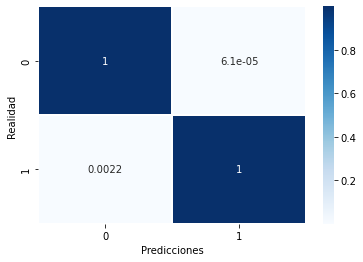

In [70]:
MetricasMatrizConfusion(y=y_train,Modelo=Arbol_Simple,X=x_train,tipo="ML")

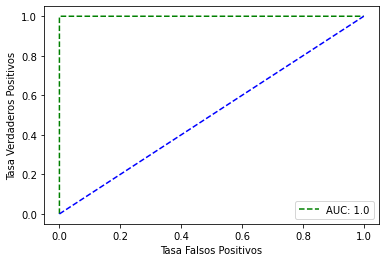

0.9999991707140975

In [71]:
curva_roc(y=y_train,Modelo=Arbol_Simple,X=x_train,tipo="ML")

**Test Error**

Accuracy: 0.7241111111111111
Reporte :               precision    recall  f1-score   support

           0       0.83      0.81      0.82      7009
           1       0.39      0.42      0.40      1991

    accuracy                           0.72      9000
   macro avg       0.61      0.61      0.61      9000
weighted avg       0.73      0.72      0.73      9000



Predicciones,0,1,All
Realidad,,,
0,5686,1323,7009
1,1160,831,1991
All,6846,2154,9000


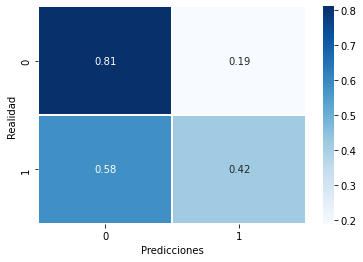

In [72]:
MetricasMatrizConfusion(y=y_test,Modelo=Arbol_Simple,X=x_test,tipo="ML")

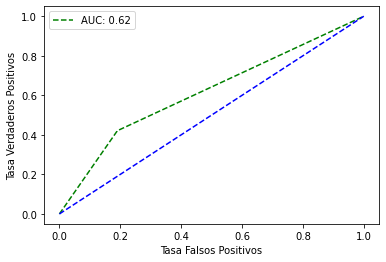

0.6152459573574021

In [73]:
curva_roc(y=y_test,Modelo=Arbol_Simple,X=x_test,tipo="ML")

* SobreAjsute: Error Train < Error Test
* underfitting: Error Train > Error Test
* Ideal= Error Train = Error Test

## **Optimización de Hiperparámetros con K-fold Cross Validation**

La optimización de hiperparámetros se refiere al proceso de encontrar la combinación óptima de hiperparámetros para un modelo de aprendizaje automático. Los hiperparámetros son variables que no se aprenden automáticamente durante el entrenamiento del modelo, sino que deben ser configuradas por el usuario antes de iniciar el proceso de entrenamiento

**Grid Search**

In [74]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [75]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [2, 4, 5, 7],
    "min_samples_split": [2, 4, 5, 7],
    "min_samples_leaf": [2, 4, 7],
    "class_weight": [None, "balanced"]
}



In [76]:
from itertools import product

In [77]:
num_models = len(list(product(*param_grid.values())))
print("Número total de modelos:", num_models)

Número total de modelos: 192


In [78]:
96*5

480

In [79]:
grid_search=GridSearchCV(Arbol_Simple,param_grid,cv=5,scoring="roc_auc")
grid_search.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 5, 7],
                         'min_samples_leaf': [2, 4, 7],
                         'min_samples_split': [2, 4, 5, 7]},
             scoring='roc_auc')

In [80]:
best_params= grid_search.best_params_

In [81]:
best_params

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 7,
 'min_samples_leaf': 7,
 'min_samples_split': 2}

In [82]:
best_model=DecisionTreeClassifier(max_depth=7,min_samples_leaf=4,min_samples_split=2,criterion="entropy")

In [83]:
best_model.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=4)

In [84]:
clases=best_model.classes_
clases_names=["0","1"]

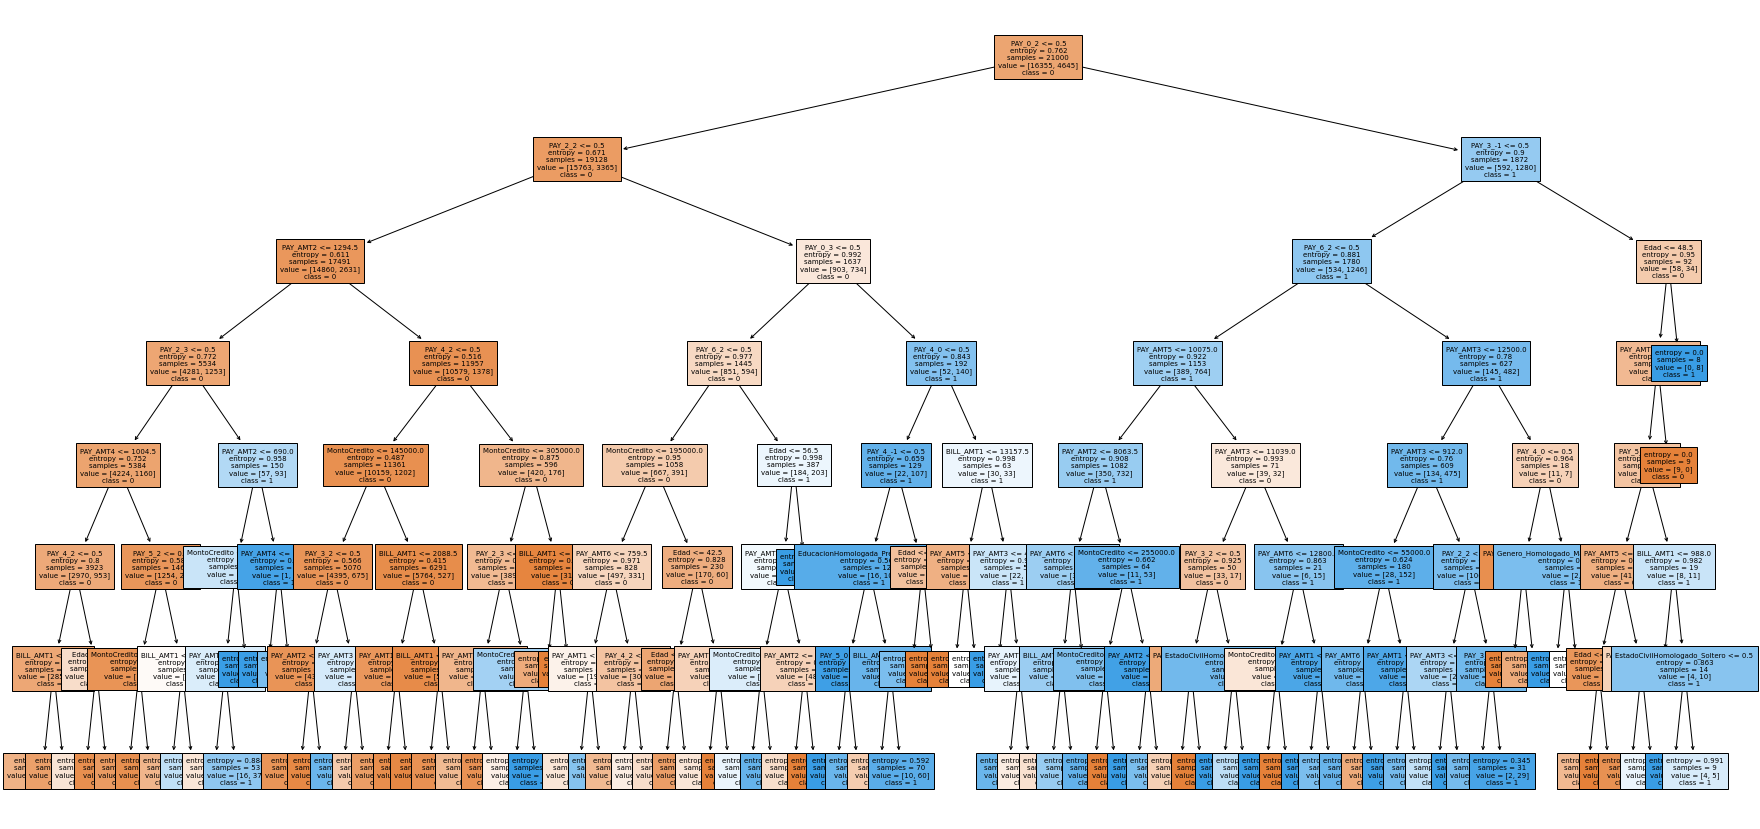

In [85]:
fig, ax= plt.subplots(figsize=(30,15))
plot=plot_tree(decision_tree=best_model,
              feature_names=x_train.columns,
              class_names=clases_names,
               filled=True,
               fontsize=7,
              ax=ax)
plt.savefig("Arbol.png")

Accuracy: 0.8262857142857143
Reporte :               precision    recall  f1-score   support

           0       0.84      0.96      0.90     16355
           1       0.71      0.36      0.48      4645

    accuracy                           0.83     21000
   macro avg       0.78      0.66      0.69     21000
weighted avg       0.81      0.83      0.80     21000



Predicciones,0,1,All
Realidad,,,
0,15690,665,16355
1,2983,1662,4645
All,18673,2327,21000


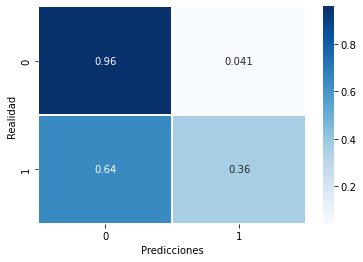

In [86]:
MetricasMatrizConfusion(y=y_train,Modelo=best_model,X=x_train,tipo="ML")

Accuracy: 0.8194444444444444
Reporte :               precision    recall  f1-score   support

           0       0.84      0.96      0.89      7009
           1       0.69      0.33      0.45      1991

    accuracy                           0.82      9000
   macro avg       0.76      0.65      0.67      9000
weighted avg       0.80      0.82      0.79      9000



Predicciones,0,1,All
Realidad,,,
0,6709,300,7009
1,1325,666,1991
All,8034,966,9000


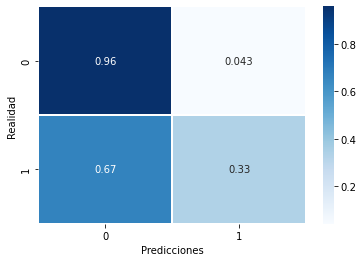

In [87]:
MetricasMatrizConfusion(y=y_test,Modelo=best_model,X=x_test,tipo="ML")

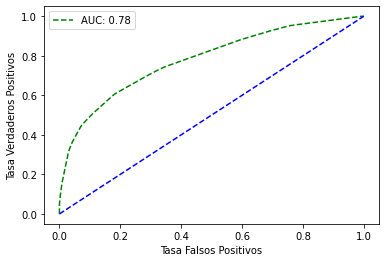

0.7800382063862255

In [88]:
curva_roc(y=y_train,Modelo=best_model,X=x_train,tipo="ML")

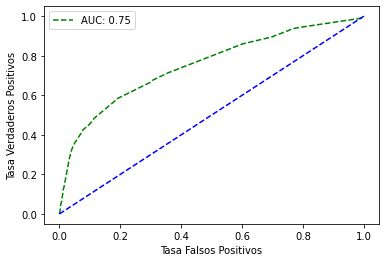

0.7514583925567752

In [89]:
curva_roc(y=y_test,Modelo=best_model,X=x_test,tipo="ML")